In [1]:
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
from util import get_transforms, get_dataset, get_image_size, get_dataloader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%reload_ext autoreload
%autoreload 2



dataset_name = 'MNIST'

batch_size = 1  # record each loss element, not mean
timesteps = 300

image_size = get_image_size(dataset_name)
transform, _ = get_transforms(image_size=image_size)
trainset, testset = get_dataset(dataset_name, transform)
trainloader, testloader = get_dataloader(trainset, testset, 1)


In [2]:
record_latent_features = torch.load('./weight/record_latent_features_power_999_100.pt')
# record_latent_features_loss = torch.load('./weight/record_latent_features_loss_power.pt')

In [3]:
def flatten_features(record_latent_Features):
    for key in record_latent_Features.keys():
        for i in range(len(record_latent_Features[key])):
            record_latent_Features[key][i] = record_latent_Features[key][i].flatten()

def calc_avg_distance(record_latent_features):

    record_feature_dist = {}
    record_feature_stats = {}

    tqdmr = tqdm(record_latent_features.keys(), desc='calculate the stats of latent features for training samples')

    for key  in tqdmr:

        rand_ids = np.random.choice(len(record_latent_features[key]), size=30000, replace=False)
        vectors = np.array(record_latent_features[key])[rand_ids,:]
        
        # Compute squared distances
        dot_product = np.dot(vectors, vectors.T)
        squared_norms = np.sum(vectors**2, axis=1, keepdims=True)
        squared_distances = squared_norms + squared_norms.T - 2 * dot_product
        
        # Ensure distances are non-negative
        squared_distances = np.maximum(squared_distances, 0)
        
        # Take the square root to get L2 distance
        distances = np.sqrt(squared_distances)

        record_feature_dist[key] = distances
        record_feature_stats[key] = (np.mean(distances), np.std(distances))
    
    return record_feature_dist, record_feature_stats

class pca_ood_detector:
    def __init__(self, record_latent_features):
        self.record_latent_features = record_latent_features

    def pca_analyze(self):
        ...

    def calc_l2_distance(self, latent):
        ...


# average distance

In [42]:
flatten_features(record_latent_features)

In [6]:
record_feature_dist, record_feature_stats = calc_avg_distance(record_latent_features)

calculate the stats of latent features for training samples: 100%|██████████| 4/4 [01:30<00:00, 22.58s/it]


In [6]:
[len(record_latent_features[key]) for key in record_latent_features.keys()]

[59968, 59968, 59968, 59968]

In [6]:
tmp = np.array(record_latent_features[5])

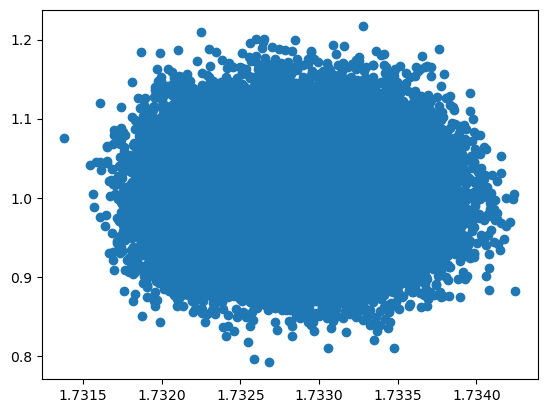

In [12]:
plt.scatter(np.linalg.norm(tmp,axis=1),record_latent_features_loss[100])

In [13]:
trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

# TSNE dimension reduction

# new power

In [10]:
tmp = np.array(record_latent_features[0])

In [11]:
tmp.shape

(60000, 64, 4, 4)

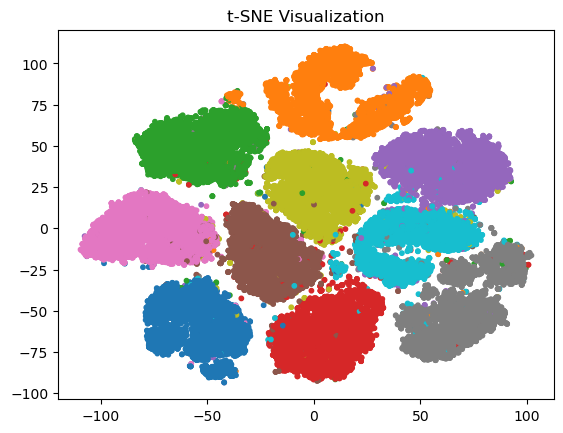

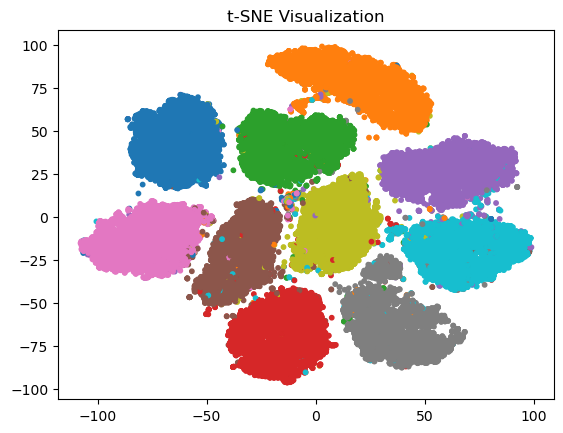

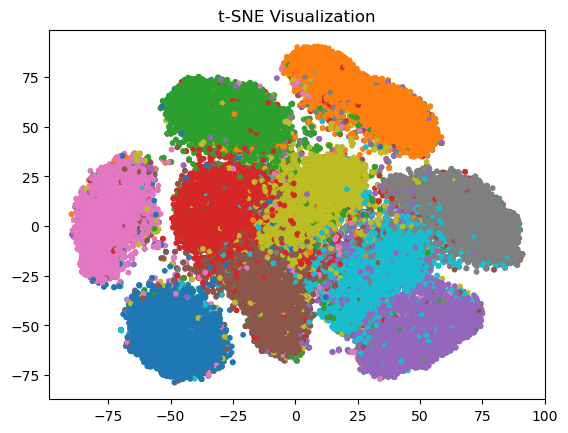

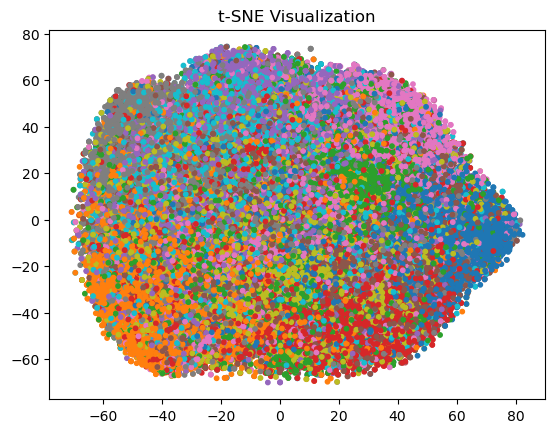

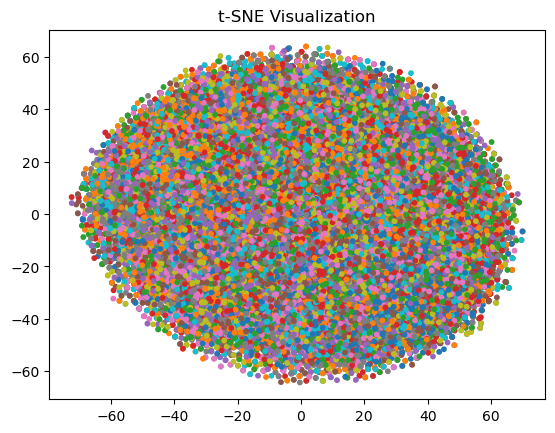

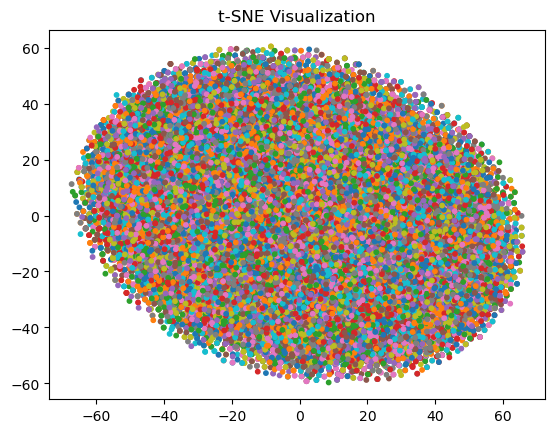

In [12]:
flatten_features(record_latent_features)
for key in record_latent_features.keys():
    tmp = np.array(record_latent_features[key])

    # Instantiate the t-SNE model
    tsne = TSNE(n_components=2, random_state=42)

    # Fit the model and transform the data to the 2D space
    matrix_embedded = tsne.fit_transform(tmp)

    # Plot the results
    # plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1])
    scatter = plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1], c=trainset.targets, cmap='tab10', s=10)
    plt.title('t-SNE Visualization')
    plt.show()


# old

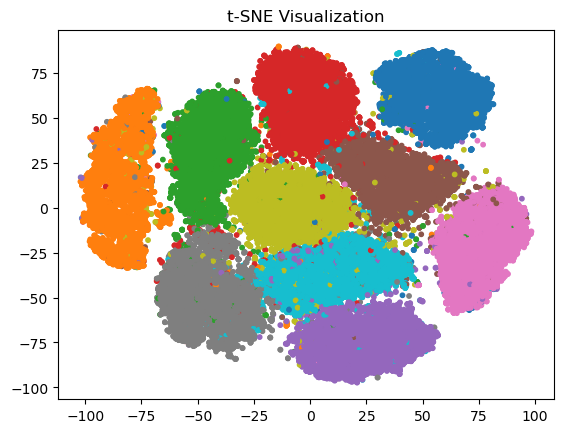

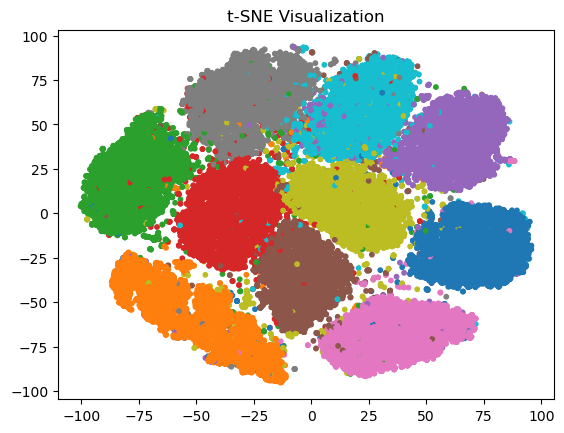

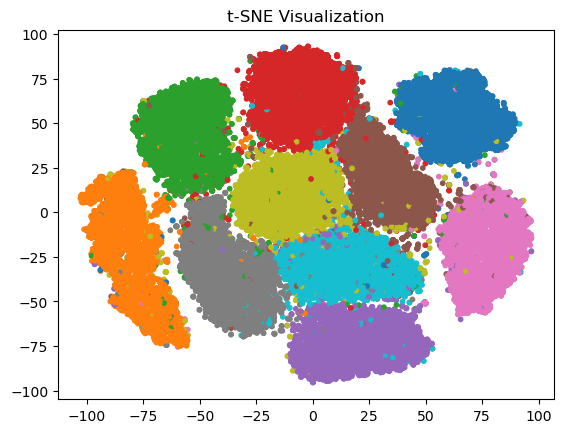

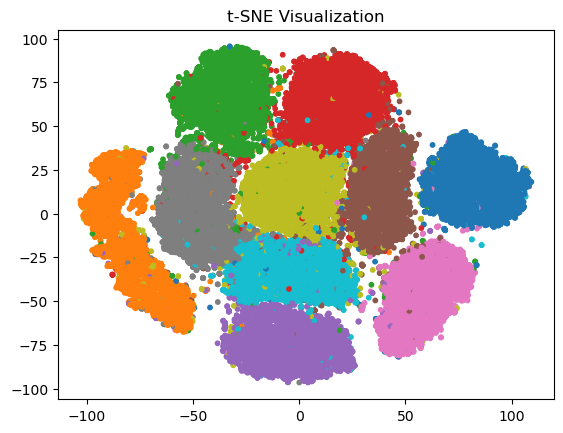

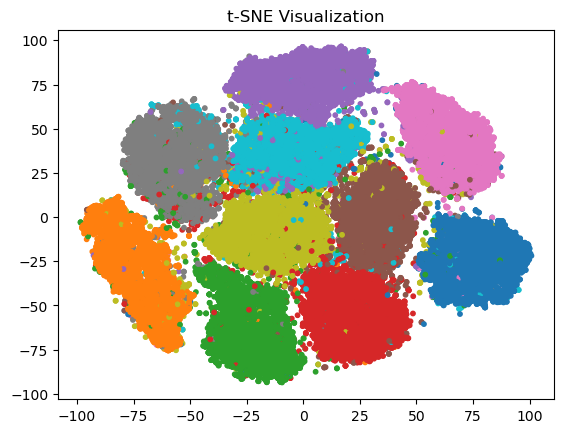

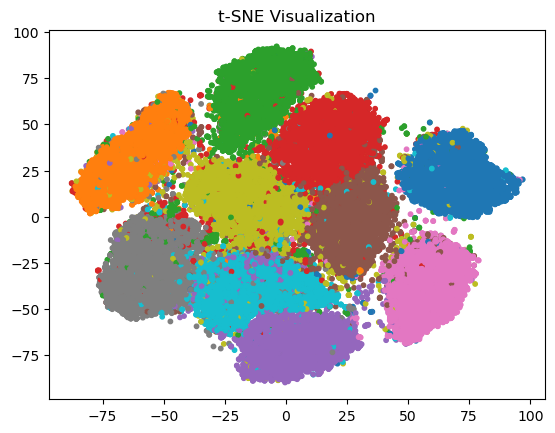

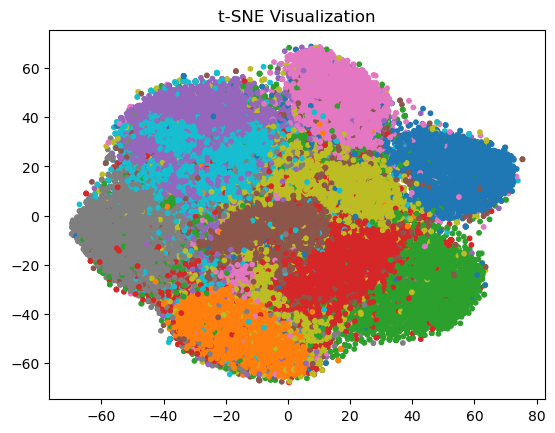

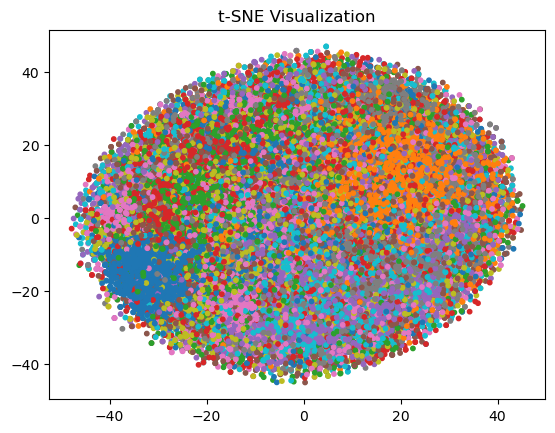

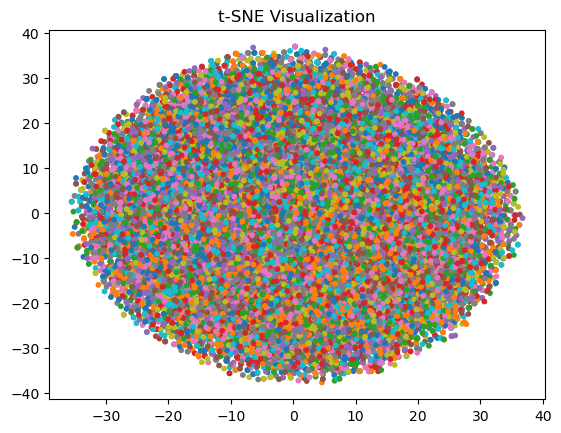

In [43]:
for key in record_latent_features.keys():
    tmp = np.array(record_latent_features[key])

    # Instantiate the t-SNE model
    tsne = TSNE(n_components=2, random_state=42)

    # Fit the model and transform the data to the 2D space
    matrix_embedded = tsne.fit_transform(tmp)

    # Plot the results
    # plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1])
    scatter = plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1], c=trainset.targets, cmap='tab10', s=10)
    plt.title('t-SNE Visualization')
    plt.show()

    (0,1,5,10,25,50,100,200,299)

# ood detector

In [4]:
class pca_ood_detector:
    def __init__(self, record_latent_features):
        
        self.record_latent_features = record_latent_features
        self.timesteps = self.record_latent_features.keys()
        flatten_features(self.record_latent_features)

    def pca_analyze(self):

        self.pca_models = { key:None for key in self.record_latent_features.keys() }
        self.pca_projected_latents = { key:None for key in self.record_latent_features.keys() }
        tqmdr = tqdm(self.record_latent_features.keys(), desc='pca_analysis')
        
        for key in tqmdr:
            pca_model = PCA(n_components='mle')
            res = pca_model.fit_transform(self.record_latent_features[key])
            self.pca_models[key] = pca_model
            self.pca_projected_latents[key] = res

    def calc_avg_distance(self):    # setting threshold

        pca_projected_latents_dist = {}
        pca_projected_latents_stats = {}

        tqdmr = tqdm(self.pca_projected_latents.keys(), desc='calculate the stats of latent features for training samples')

        for key  in tqdmr:

            rand_ids = np.random.choice(len(self.pca_projected_latents[key]), size=10000, replace=False)
            vectors = np.array(self.pca_projected_latents[key])[rand_ids,:]
            
            # Compute squared distances
            dot_product = np.dot(vectors, vectors.T)
            squared_norms = np.sum(vectors**2, axis=1, keepdims=True)
            squared_distances = squared_norms + squared_norms.T - 2 * dot_product
            
            # Ensure distances are non-negative
            squared_distances = np.maximum(squared_distances, 0)
            
            # Take the square root to get L2 distance
            distances = np.sqrt(squared_distances)

            pca_projected_latents_dist[key] = distances
            pca_projected_latents_stats[key] = (np.mean(distances), np.std(distances))

        self.pca_projected_latents_dist = pca_projected_latents_dist
        self.pca_projected_latents_stats = pca_projected_latents_stats

    def set_threshold(self, sigma_threshold=5): # mean+3*std

        self.thresholds = { key:self.pca_projected_latents_stats[key][0]+sigma_threshold*self.pca_projected_latents_stats[key][1] 
                          for key in self.pca_projected_latents_stats.keys() }

    def detect_l2_distance_ood(self, latent, timestep):
        assert timestep in self.timesteps 
        projected_latent = self.pca_models[timestep].transform(latent)
        l2_distances = np.linalg.norm(self.pca_projected_latents[timestep] - projected_latent, axis=1)
        min_distance = np.min(l2_distances)
        if min_distance > self.thresholds[timestep]:
            print('ood sample!')
            return True, min_distance
        else:
            return False, min_distance


In [6]:
detector = pca_ood_detector(record_latent_features)
detector.pca_analyze()

pca_analysis: 100%|██████████| 9/9 [02:35<00:00, 17.25s/it]


In [7]:
detector.calc_avg_distance()

calculate the stats of latent features for training samples:   0%|          | 0/9 [00:00<?, ?it/s]

calculate the stats of latent features for training samples: 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


In [8]:
detector.set_threshold(3)

In [9]:
detector.pca_projected_latents[1].shape

(59904, 493)

In [5]:
import wandb
import torch
import argparse
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from unet import UNet
from model import DiffusionModel
from util import get_transforms, get_dataset, get_image_size, get_dataloader
import sys
from unet_power import UNet



def infer(unet, diffusion_model, device, T, reverse_transform, n):

    unet.train()
    sd = []
    total_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n))
        for _ in tqdmr:
            samples = []
            image = torch.randn((1, 1, 32, 32)).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                samples_at_step = []
                for _ in range(T):
                    image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                    samples_at_step.append(image)
                samples_at_step = torch.cat(samples_at_step, dim=0)
                mean_sample = samples_at_step.mean(dim=0)
                sd_sample = samples_at_step.std(dim=0).mean()
                if i % 50 == 0:
                    samples.append(reverse_transform(mean_sample).cpu())
            sd.append(sd_sample.cpu().item())
            total_samples.append(samples)
    return total_samples, sd

def infer_ood(unet, diffusion_model, ood_detector, device, reverse_transform, n_imgs):

    unet.eval()
    unet._start_ood_detection(ood_detector, (0,1,5,10,25,50,100,200,299))
    
    infer_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n_imgs))
        for _ in tqdmr:
            samples = []
            image = torch.randn((1, 1, 28, 28)).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                # print(i)
                if i % 50 == 0:
                    samples.append(reverse_transform(image).cpu())
            infer_samples.append(samples)

    return infer_samples


def infer_ood_abnormal(unet, diffusion_model, ood_detector, device, reverse_transform, n_imgs):

    unet.eval()
    unet._start_ood_detection(ood_detector, (0,1,5,10,25,50,100,200,299))
    
    infer_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n_imgs))
        for _ in tqdmr:
            samples = []
            image = torch.randint(-10,10,(1, 1, 28, 28),dtype=torch.float).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                # print(i)
                if i % 50 == 0:
                    samples.append(reverse_transform(image).cpu())
            infer_samples.append(samples)

    return infer_samples

In [30]:
TIMESTEPS = 1000
IMAGE_SIZE = (32, 32)
device = 'cuda'
n_imgs = 100
N = 20
T = 2


unet = UNet(T=TIMESTEPS, ch=32, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, 
                 dropout=0.1).to(device)
unet.load_state_dict(torch.load('weight/parameters_power.pkl'))
diffusion_model = DiffusionModel(timesteps=TIMESTEPS)

_, reverse_transform = get_transforms(image_size=IMAGE_SIZE)

# infer_samples = infer_ood(unet, diffusion_model, detector, device, reverse_transform, n_imgs)
# infer_samples = infer_ood_abnormal(unet, diffusion_model, detector, device, reverse_transform, n_imgs)
total_samples, sd = infer(unet, diffusion_model, device, T, reverse_transform, N)

100%|██████████| 20/20 [03:12<00:00,  9.62s/it]


In [12]:
def lower_triangular_flatten(matrix):
    # Extract the lower triangular part using np.tril_indices
    lower_triangular_indices = np.tril_indices(matrix.shape[0])
    
    # Use the indices to extract the lower triangular elements
    lower_triangular_elements = matrix[lower_triangular_indices]

    return lower_triangular_elements

In [13]:
detector.pca_projected_latents_stats[0]

(9.962284104305818, 4.603818455124633)

(array([1.000000e+04, 1.600000e+01, 7.154000e+03, 1.250320e+05,
        5.840690e+05, 1.403158e+06, 2.366857e+06, 3.265363e+06,
        3.953988e+06, 4.379148e+06, 4.522790e+06, 4.422515e+06,
        4.125593e+06, 3.705212e+06, 3.227319e+06, 2.749530e+06,
        2.294031e+06, 1.889783e+06, 1.534649e+06, 1.237044e+06,
        9.852760e+05, 7.774990e+05, 6.077600e+05, 4.688530e+05,
        3.591620e+05, 2.720010e+05, 2.031120e+05, 1.505600e+05,
        1.099080e+05, 8.018100e+04, 5.741700e+04, 4.061400e+04,
        2.835300e+04, 1.986700e+04, 1.358500e+04, 9.390000e+03,
        6.267000e+03, 4.071000e+03, 2.799000e+03, 1.846000e+03,
        1.254000e+03, 8.250000e+02, 4.710000e+02, 3.190000e+02,
        1.960000e+02, 9.800000e+01, 4.200000e+01, 1.700000e+01,
        5.000000e+00, 1.000000e+00]),
 array([ 0.        ,  1.3748673 ,  2.74973461,  4.12460191,  5.49946922,
         6.87433652,  8.24920383,  9.62407113, 10.99893844, 12.37380574,
        13.74867305, 15.12354035, 16.49840766, 1

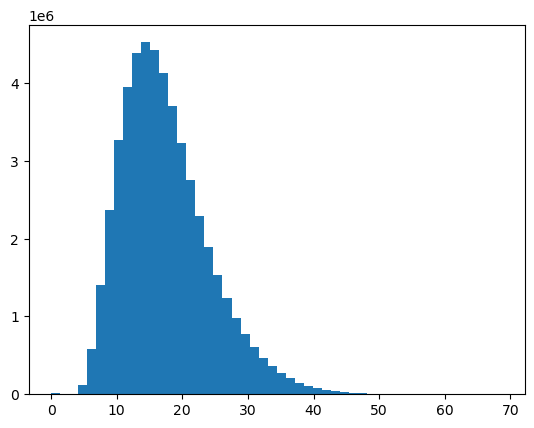

In [14]:
plt.hist(lower_triangular_flatten(detector.pca_projected_latents_dist[299]),bins=50)

In [25]:
unet.ood_detect_res

[(True, 400.17477843747423),
 (False, 21.131759429880628),
 (False, 7.82449742687177),
 (False, 7.409350568706502),
 (False, 6.882330611452917),
 (False, 5.184586713019941),
 (False, 5.428748499845044),
 (False, 5.5041651189814695),
 (False, 6.67506858151449),
 (True, 455.53995538732255),
 (True, 46.76654556824617),
 (False, 9.771233002299248),
 (False, 7.475158588677908),
 (False, 9.11033713054489),
 (False, 7.045249372288053),
 (False, 4.080901625321487),
 (False, 5.641608272234754),
 (False, 5.714259885450477),
 (True, 444.961639117715),
 (False, 34.63955961964576),
 (False, 7.038792838922032),
 (False, 6.944840051565659),
 (False, 6.4051130680443285),
 (False, 5.7472703960886315),
 (False, 4.491089974336974),
 (False, 6.26958582936495),
 (False, 7.137856860414232),
 (True, 444.39661093577234),
 (False, 30.926597054062032),
 (False, 7.630852528007893),
 (False, 6.114142646274612),
 (False, 5.792268467356089),
 (False, 3.9517979124147367),
 (False, 3.2108400495731515),
 (False, 10.48

In [24]:
unet.ood_detector

In [37]:
detector.pca_models[0].transform(np.random.randn(1,512))

array([[ 2.54550104e+00,  3.10309491e+00,  5.49073621e+00,
        -3.00501180e+00,  1.51051969e+01, -9.23123768e+00,
        -1.38781300e+00, -2.53154119e+00, -1.84989263e+00,
        -1.55675553e+00, -3.04200642e+00,  2.52645304e+00,
        -3.83899937e+00,  9.92622907e-01, -1.18826225e+00,
        -2.24639926e+00, -4.09735724e+00,  3.62514729e+00,
        -2.00815422e+00,  4.88361654e+00, -1.63710690e+00,
         4.06068784e+00, -5.14470815e-01, -2.94875203e+00,
        -3.21480841e-01,  6.30110329e-01,  2.99288276e+00,
        -2.30807668e-02, -4.49164755e-01,  6.51009583e-01,
         1.32693704e+00,  1.59697496e+00,  1.50705225e+00,
         7.60530159e-01,  1.90679181e+00, -1.17436952e+00,
         2.15413106e+00,  1.40545650e+00,  1.34069096e+00,
        -9.09895714e-02, -1.15236646e+00, -1.13937913e+00,
        -5.05328859e-01, -6.70381270e-01, -1.31738062e+00,
         4.24953584e-01,  9.47372790e-01, -4.02174355e-01,
         9.98556207e-01, -1.21572921e+00,  1.95336582e+0

In [14]:
total_samples[0][0].shape

torch.Size([1, 32, 32])

In [25]:
len(total_samples)

100

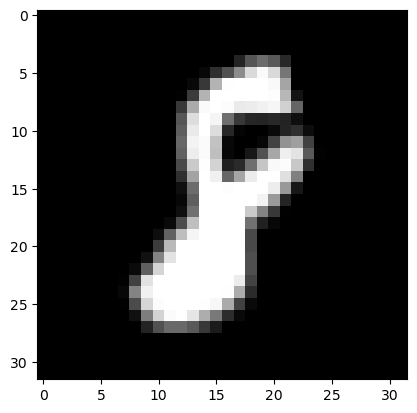

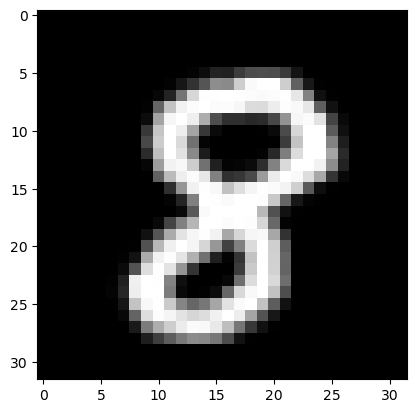

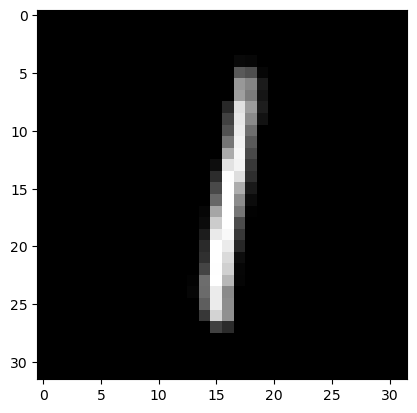

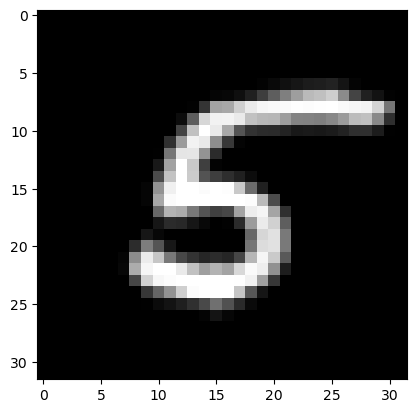

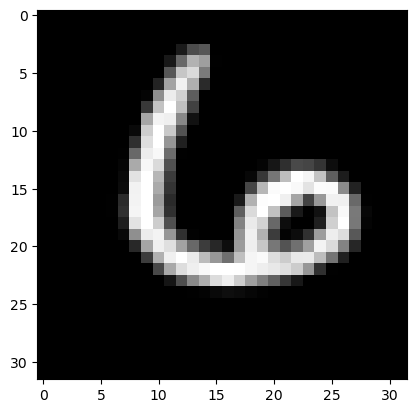

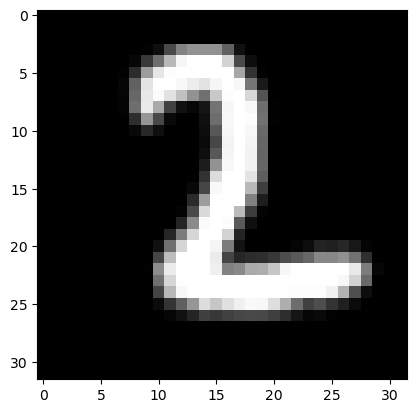

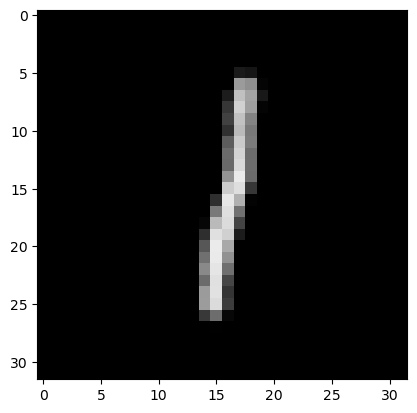

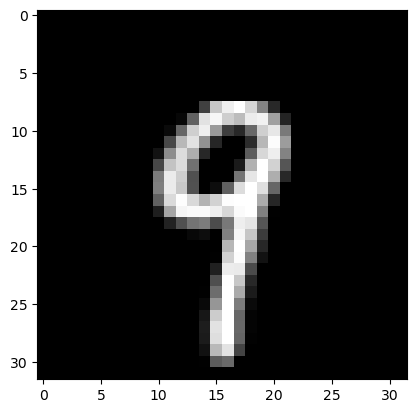

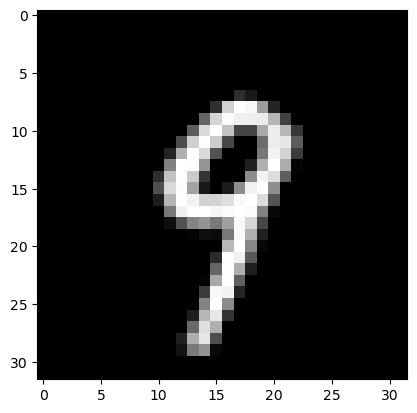

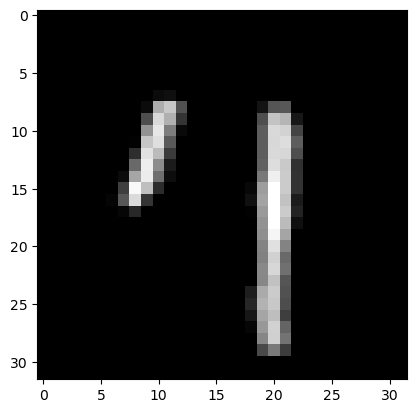

In [33]:
img_idx = np.random.choice(len(total_samples),10,replace=False)

for idx in img_idx:
    fig,ax = plt.subplots()
    ax.imshow(total_samples[idx][-1][-1],cmap='gray',vmin=0, vmax=255)


In [ ]:
for img in total_samples:
    for i in img:
        fig,ax = plt.subplots()
        ax.imshow(i[0])

: 

# OOD detector new power

In [4]:
record_latent_features = torch.load('./weight/record_latent_features_power_999_100_new.pt')
flatten_features(record_latent_features)

In [5]:
record_latent_features_loss = torch.load('./weight/record_latent_features_loss_power_999_100_new.pt')

In [6]:
record_latent_features[999][0].shape

(1024,)

In [34]:
tmp = record_latent_features[999]

In [35]:
np.array(record_latent_features_loss[999]).mean(axis=(1,2,3))

array([3.77692845e-05, 7.38075367e-05, 6.25217752e-05, ...,
       3.99448004e-05, 6.90905428e-05, 6.19616635e-05])

In [11]:
np.array(record_latent_features_loss[0]).shape

(60000, 32, 32)

KeyboardInterrupt: 

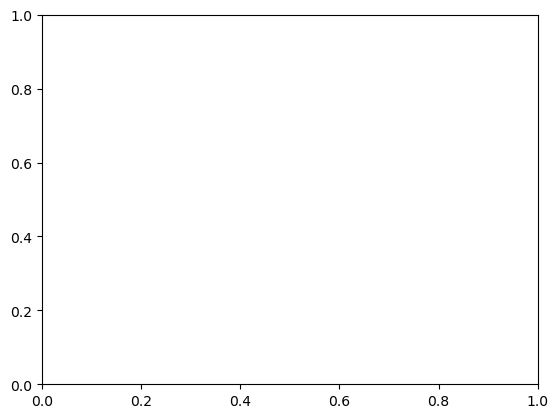

In [7]:
for timestep in record_latent_features.keys():
    fig,ax = plt.subplots()
    ax.scatter(np.array(record_latent_features_loss[timestep]).mean(axis=(1,2,3)), np.linalg.norm(record_latent_features[timestep],axis=1))
    ax.semilogx()


[]

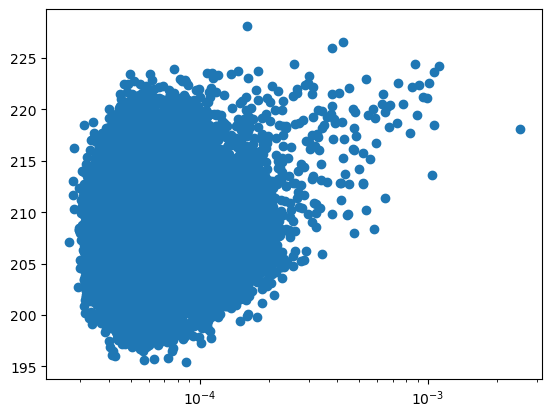

In [ ]:
timestep = 999
plt.scatter(np.array(record_latent_features_loss[timestep]).mean(axis=(1,2,3)), np.linalg.norm(record_latent_features[timestep],axis=1))
plt.semilogx()

[]

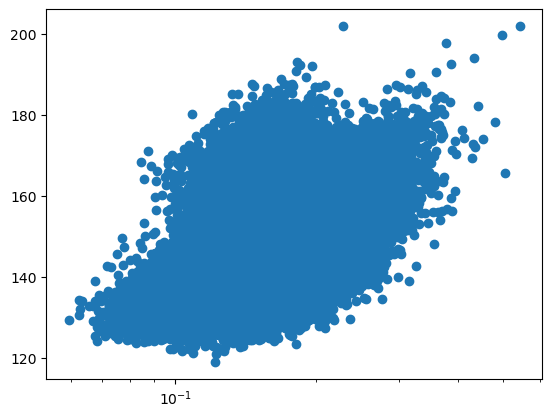

In [ ]:
timestep = 0
plt.scatter(np.array(record_latent_features_loss[timestep]).mean(axis=(1,2,3)), np.linalg.norm(record_latent_features[timestep],axis=1))
plt.semilogx()

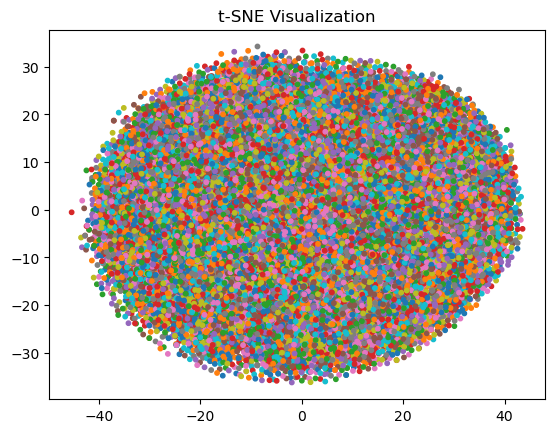

In [20]:

tmp = np.array(record_latent_features[999])

# Instantiate the t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit the model and transform the data to the 2D space
matrix_embedded = tsne.fit_transform(tmp)

# Plot the results
# plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1])
scatter = plt.scatter(matrix_embedded[:, 0], matrix_embedded[:, 1], c=trainset.targets, cmap='tab10', s=10)
plt.title('t-SNE Visualization')
plt.show()


In [5]:
class pca_ood_detector:
    def __init__(self, record_latent_features):
        
        self.record_latent_features = record_latent_features
        self.timesteps = [key for key in self.record_latent_features]
        flatten_features(self.record_latent_features)

    def pca_analyze(self):

        self.pca_models = { key:None for key in self.record_latent_features.keys() }
        self.pca_projected_latents = { key:None for key in self.record_latent_features.keys() }
        tqmdr = tqdm(self.record_latent_features.keys(), desc='pca_analysis')
        
        for key in tqmdr:
            pca_model = PCA(n_components='mle')
            res = pca_model.fit_transform(self.record_latent_features[key])
            self.pca_models[key] = pca_model
            self.pca_projected_latents[key] = res

    def calc_avg_distance(self):    # setting threshold

        pca_projected_latents_dist = {}
        pca_projected_latents_stats = {}

        tqdmr = tqdm(self.pca_projected_latents.keys(), desc='calculate the stats of latent features for training samples')

        for key  in tqdmr:

            rand_ids = np.random.choice(len(self.pca_projected_latents[key]), size=10000, replace=False)
            vectors = np.array(self.pca_projected_latents[key])[rand_ids,:]
            
            # Compute squared distances
            dot_product = np.dot(vectors, vectors.T)
            squared_norms = np.sum(vectors**2, axis=1, keepdims=True)
            squared_distances = squared_norms + squared_norms.T - 2 * dot_product
            
            # Ensure distances are non-negative
            squared_distances = np.maximum(squared_distances, 0)
            
            # Take the square root to get L2 distance
            distances = np.sqrt(squared_distances)

            pca_projected_latents_dist[key] = distances
            pca_projected_latents_stats[key] = (np.mean(distances), np.std(distances))

        self.pca_projected_latents_dist = pca_projected_latents_dist
        self.pca_projected_latents_stats = pca_projected_latents_stats

    def set_threshold(self, sigma_threshold=5): # mean+3*std

        self.thresholds = { key:self.pca_projected_latents_stats[key][0]+sigma_threshold*self.pca_projected_latents_stats[key][1] 
                          for key in self.pca_projected_latents_stats.keys() }

    def detect_l2_distance_ood(self, latent, timestep):
        assert timestep in self.timesteps 
        projected_latent = self.pca_models[timestep].transform(latent)
        l2_distances = np.linalg.norm(self.pca_projected_latents[timestep] - projected_latent, axis=1)
        min_distance = np.min(l2_distances)
        if min_distance > self.thresholds[timestep]:
            print('ood sample!')
            return True, min_distance
        else:
            return False, min_distance


In [7]:
ood_detector = pca_ood_detector(record_latent_features)
ood_detector.pca_analyze()
ood_detector.calc_avg_distance()
ood_detector.set_threshold(3)


pca_analysis: 100%|██████████| 6/6 [19:04<00:00, 190.71s/it]
calculate the stats of latent features for training samples: 100%|██████████| 6/6 [01:05<00:00, 10.97s/it]


In [1]:
torch.save(ood_detector, './weight/ood_detector_ipynb_999_100.pt')

NameError: name 'torch' is not defined

In [6]:
import pickle
with open(f'./results/stored_detector_power_999_100_{1}.pkl', 'rb') as file:
    ood_detector_1 = pickle.load(file)

(array([1.0000000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.4000000e+01, 3.2800000e+02,
        3.1340000e+03, 2.3498000e+04, 1.2093600e+05, 4.6355600e+05,
        1.3554340e+06, 3.1319140e+06, 5.8727720e+06, 9.1340580e+06,
        1.2043320e+07, 1.3707056e+07, 1.3668914e+07, 1.2149902e+07,
        9.7404640e+06, 7.1122880e+06, 4.7833240e+06, 2.9875400e+06,
        1.7490180e+06, 9.6922600e+05, 5.0646400e+05, 2.5215200e+05,
        1.2072800e+05, 5.4808000e+04, 2.3994000e+04, 9.6920000e+03,
        3.5640000e+03, 1.3580000e+03, 3.9400000e+02, 1.1400000e+02,
        2.8000000e+01, 8.0000000e+00]),
 array([  0.        ,   3.54879057,   7.09758113,  10.6463717 ,
         14.19516226,  17.74395283,  21.29274339,  24.84153396,
         28.3903

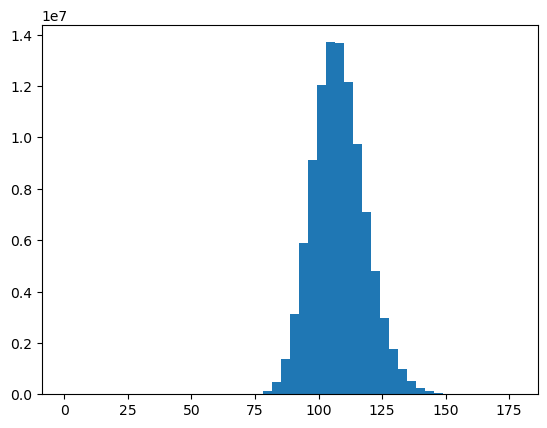

In [9]:
plt.hist(ood_detector_1.pca_projected_latents_dist[999].flatten(),bins=50)

In [10]:
import wandb
import torch
import argparse
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from unet import UNet
from model import DiffusionModel
from util import get_transforms, get_dataset, get_image_size, get_dataloader
import sys
from unet_power import UNet



def infer(unet, diffusion_model, device, T, reverse_transform, n):

    unet.train()
    sd = []
    total_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n))
        for _ in tqdmr:
            samples = []
            image = torch.randn((1, 1, 32, 32)).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                samples_at_step = []
                for _ in range(T):
                    image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                    samples_at_step.append(image)
                samples_at_step = torch.cat(samples_at_step, dim=0)
                mean_sample = samples_at_step.mean(dim=0)
                sd_sample = samples_at_step.std(dim=0).mean()
                if i % 50 == 0:
                    samples.append(reverse_transform(mean_sample).cpu())
            sd.append(sd_sample.cpu().item())
            total_samples.append(samples)
    return total_samples, sd

def infer_ood(unet, diffusion_model, ood_detector, device, reverse_transform, n_imgs):

    unet.eval()
    unet._start_ood_detection(ood_detector, (0,1,5,10,25,50,100,200,299))
    
    infer_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n_imgs))
        for _ in tqdmr:
            samples = []
            image = torch.randn((1, 1, 28, 28)).to(device)
            for i in reversed(range(diffusion_model.timesteps)):
                image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                # print(i)
                if i % 50 == 0:
                    samples.append(reverse_transform(image).cpu())
            infer_samples.append(samples)

    return infer_samples


def infer_ood_abnormal(unet, diffusion_model, ood_detector, device, reverse_transform, n_imgs):

    unet.eval()
    unet._start_ood_detection(ood_detector, (0,199,399,599,799,999))
    
    infer_samples = []
    with torch.no_grad():
        tqdmr = tqdm(range(n_imgs))
        for _ in tqdmr:
            samples = []
            # image = torch.randint(0,255,(1, 1, 32, 32),dtype=torch.float).to(device)
            image = torch.randn((1, 1, 32, 32)).to(device) * 2
            for i in reversed(range(diffusion_model.timesteps)):
                image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
                # print(i)
                if i % 50 == 0:
                    samples.append(reverse_transform(image).cpu())
            infer_samples.append(samples)

    return infer_samples

In [11]:
TIMESTEPS = 1000
IMAGE_SIZE = (32, 32)
device = 'cuda'
n_imgs = 5
N = 20
T = 2

unet = UNet(T=TIMESTEPS, ch=32, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, 
                 dropout=0.1).to(device)
unet.load_state_dict(torch.load('weight/parameters_power.pkl'))
diffusion_model = DiffusionModel(timesteps=TIMESTEPS)

_, reverse_transform = get_transforms(image_size=IMAGE_SIZE)

infer_samples = infer_ood_abnormal(unet, diffusion_model, ood_detector_1, device, reverse_transform, n_imgs)

  0%|          | 0/5 [00:00<?, ?it/s]

(1, 1024)
[[-7.1426525  -4.53012    -5.708159   ... -2.8259816  -0.32881248
  -3.7938843 ]]
ood sample!
(1, 1024)
[[ 1.7567592   0.4536947   3.899517   ...  4.2210884  -0.43330956
  -3.5545692 ]]
(1, 1024)
[[  4.697755    0.2740205  -2.4827356 ...   2.1277478  -8.099492
  -12.239641 ]]
(1, 1024)
[[  1.9947577   4.81384     4.1528845 ...  -9.696148  -11.087011
   -2.2379093]]
(1, 1024)
[[  1.2822695    4.580868     3.5986767  ... -12.37021    -10.166144
    0.04959941]]
(1, 1024)
[[0.56728625 0.06880111 3.7062593  ... 4.056369   3.8615408  2.1545467 ]]


 20%|██        | 1/5 [00:46<03:05, 46.40s/it]

(1, 1024)
[[-1.4518204   2.9968886  -5.122879   ... -9.305782    0.01415837
   0.9565946 ]]
ood sample!
(1, 1024)
[[ 3.429096   1.6010447  2.8870125 ... -5.115177   7.2234316 -4.0956593]]
(1, 1024)
[[ 2.3027937  1.926387   2.9634957 ... -7.138995   2.0368183 -8.00696  ]]
(1, 1024)
[[ 1.8453786  0.7748046  4.8452907 ... -9.904465  -6.0876846  0.5868919]]
(1, 1024)
[[ -0.16010836  -0.60451293   2.768476   ... -13.099813    -3.6670032
   -4.761285  ]]
(1, 1024)
[[-1.1429563  -0.968962    2.0751832  ...  0.48196435  2.5146031
   2.2910652 ]]


 40%|████      | 2/5 [01:21<01:59, 39.90s/it]

(1, 1024)
[[ -4.442208   -13.336449    -8.083425   ...  -0.54685056 -13.381688
   11.303519  ]]
ood sample!
(1, 1024)
[[ 1.7222271 -3.8410494 -6.5165167 ... -0.8645079  1.7470407  3.5919566]]
(1, 1024)
[[  1.4936237  -4.380969   -1.8139169 ...  -3.0255544   4.995013
  -10.562446 ]]
(1, 1024)
[[ -1.4011946   1.7060714   3.0785713 ... -10.712458   28.859121
   -1.0010836]]
(1, 1024)
[[-3.4843416  -3.2298315  12.185331   ... -0.7003772  12.29443
  -0.07188737]]
(1, 1024)
[[-3.2934086 -2.0310717  5.7275496 ...  7.7700305 11.094963   1.8143401]]


 60%|██████    | 3/5 [01:53<01:12, 36.36s/it]

(1, 1024)
[[ 1.237218   -2.8062072   3.3867755  ... -0.75779915 -7.7119336
  -4.6775246 ]]
ood sample!
(1, 1024)
[[ 0.0326606  0.2048006  4.2669353 ... -4.970916   5.357995   0.4134282]]
(1, 1024)
[[ 2.2063725  3.6893387  1.5894561 ... -1.9530745  1.4775724 12.753748 ]]
(1, 1024)
[[ 2.3911572 -3.6568394  8.738499  ... 10.408713  19.629454   5.568404 ]]
(1, 1024)
[[ -1.3123333  -3.4788737   6.842436  ... -10.160439   15.769878
   -1.1528215]]
(1, 1024)
[[-3.4656758  -2.3416224   7.1374197  ... -0.97856814 13.47412
   3.7655432 ]]


 80%|████████  | 4/5 [02:25<00:34, 34.53s/it]

(1, 1024)
[[ 0.2623133  -2.5552607  -5.766965   ...  0.64983207  5.4647083
   6.460335  ]]
ood sample!
(1, 1024)
[[ 2.6594393 -1.5943801 -5.213503  ... -3.709043   5.3682466  2.4955401]]
(1, 1024)
[[ 0.4915155 -2.5957928  1.5687742 ...  5.4247293 15.098011  -4.6626234]]
(1, 1024)
[[ 5.9873943 -7.8576202 -6.147603  ... -1.4495473 11.670474  -6.0499716]]
(1, 1024)
[[ 3.9528177 -5.5991955 -5.442694  ... -9.936233  18.875317  -8.088    ]]
(1, 1024)
[[-0.62748057 -1.6969128  -0.24095789 ... -3.624756   16.14666
   0.30746806]]


100%|██████████| 5/5 [02:57<00:00, 35.52s/it]


In [90]:
unet.ood_detect_res

[(True, 205.93335610767681),
 (True, 207.6815773725227),
 (True, 205.49050382017307),
 (True, 202.62922132905075),
 (True, 205.2644440751796)]

In [95]:
ood_detector.pca_projected_latents

{999: array([[ -1.26733989,  -6.04305579,   2.73360219, ...,  -0.12433022,
          -0.01805012,   0.12875046],
        [-10.22451867,   0.23725461,   3.07045092, ...,  -0.03260925,
          -0.06343462,  -0.08889725],
        [  5.08952373,   5.612959  ,   0.6485977 , ...,   0.09573736,
          -0.16225762,  -0.11655255],
        ...,
        [ -6.94159305,   5.31614439,   2.49592326, ...,   0.07335127,
           0.01450148,   0.07709276],
        [  0.7496374 ,  -3.37546905,   2.83264029, ...,  -0.06087528,
          -0.10023181,   0.06677012],
        [  3.07866673,  -4.13181514,   2.33241123, ...,  -0.02925392,
          -0.04625514,  -0.0291034 ]])}

In [92]:
ood_detector.pca_projected_latents_stats

{999: (28.767966453965734, 2.5858301965306953)}

In [104]:
ood_detector.record_latent_features[999][0].reshape(-1, 1).shape

(1024, 1)

In [105]:
ood_detector.detect_l2_distance_ood(ood_detector.record_latent_features[999][0].reshape(1, -1),999)

(False, 1.6100334057604713e-13)

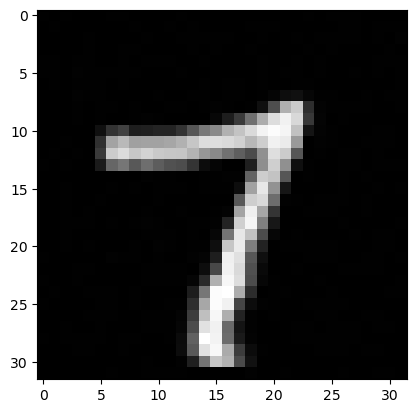

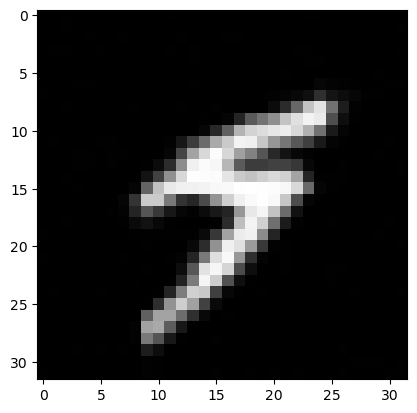

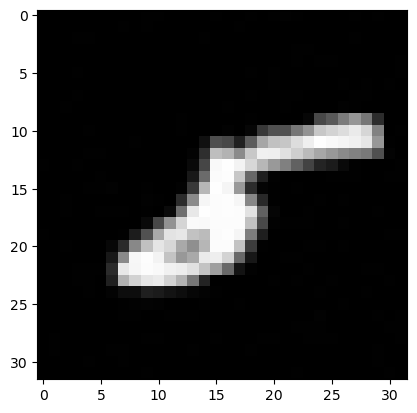

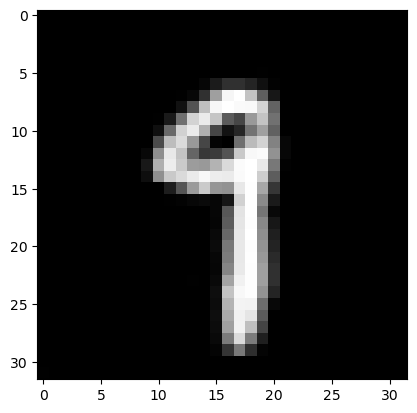

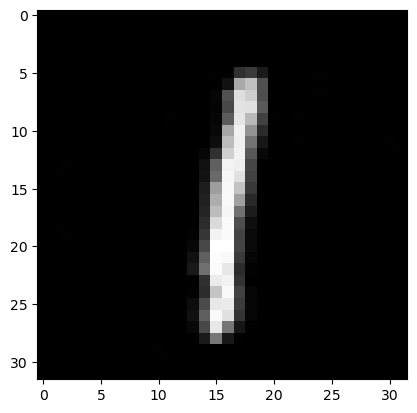

: 

In [ ]:
# img_idx = np.random.choice(len(total_samples),10,replace=False)

for idx in range(n_imgs):
    fig,ax = plt.subplots()
    ax.imshow(infer_samples[idx][-1][-1][0],cmap='gray',vmin=0, vmax=255)
